In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# =========================================================
# 1. Imports
# =========================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


2025-12-05 04:58:37.742421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764910717.952081      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764910718.016226      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# =========================================================
# 1. Imports
# =========================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [4]:
# =========================================================
# 2. Hyperparameters
# =========================================================
img_size = 224       # Resize images
num_classes = 4       # 4-class classification
patch_size = 16       # ViT patch size
projection_dim = 64   # Patch embedding dimension
transformer_layers = 8
num_heads = 4
mlp_head_units = [256, 128]  # MLP Head for Transformer


In [5]:
# =========================================================
# 2. Dataset Loading (from directory)
# =========================================================
# Replace with your dataset path
DATASET_DIR = "/kaggle/input/alzheimer-mri-1/alzheimer_new"  

img_size = 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 4400 files belonging to 4 classes.
Using 3520 files for training.


I0000 00:00:1764910732.081232      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 4400 files belonging to 4 classes.
Using 880 files for validation.
Classes: ['MildDemented', 'Moderate Dementia', 'NonDemented', 'Very mild Dementia']


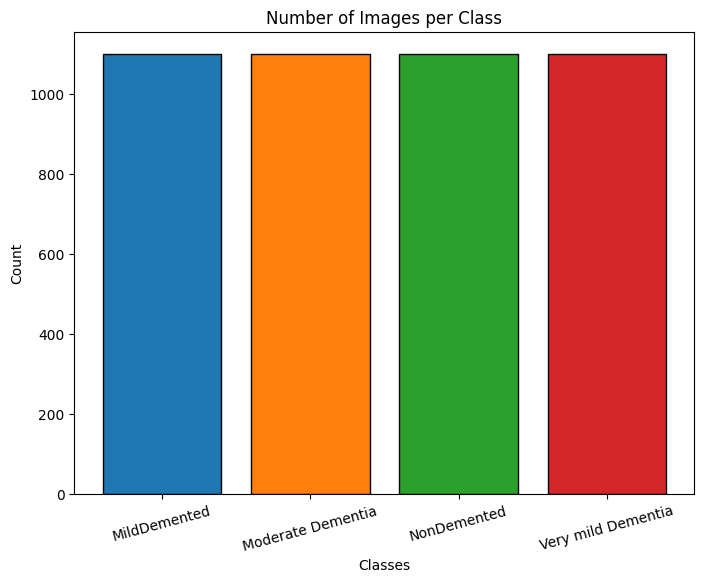

✅ Saved class_count_histogram.png


In [6]:
# # =========================================================
# # Histogram of Image Counts per Class
# # =========================================================
# import os
# import matplotlib.pyplot as plt

# class_counts = {cls: len(os.listdir(os.path.join(DATASET_DIR, cls))) for cls in class_names}

# plt.figure(figsize=(8,6))
# plt.bar(class_counts.keys(), class_counts.values(), color="skyblue", edgecolor="black")
# plt.title("Number of Images per Class")
# plt.xlabel("Classes")
# plt.ylabel("Count")
# plt.xticks(rotation=15)

# # ✅ Save high resolution
# plt.savefig("class_count_histogram.png", dpi=300, bbox_inches="tight")
# plt.show()

# print("✅ Saved class_count_histogram.png")
# =========================================================
# Histogram of Image Counts per Class (Different Colors)
# =========================================================
import os
import matplotlib.pyplot as plt

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(DATASET_DIR, cls))) for cls in class_names}

# Create colors (one unique color per class)
colors = plt.cm.tab10.colors[:len(class_names)]  # up to 10 distinct colors

plt.figure(figsize=(8,6))
plt.bar(class_counts.keys(), class_counts.values(), 
        color=colors, edgecolor="black")

plt.title("Number of Images per Class")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=15)

# ✅ Save high resolution
plt.savefig("class_count_histogram.png", dpi=600, bbox_inches="tight")
plt.show()

print("✅ Saved class_count_histogram.png")


In [7]:
# =========================================================
# 3. Convert Dataset to NumPy Arrays
# =========================================================
def dataset_to_numpy(dataset, max_batches=None):
    X, y = [], []
    for i, (images, labels) in enumerate(dataset):
        X.append(images.numpy())
        y.append(labels.numpy())
        if max_batches and i+1 >= max_batches:
            break
    return np.concatenate(X), np.concatenate(y)

X_train, y_train = dataset_to_numpy(train_ds)
X_val, y_val = dataset_to_numpy(val_ds)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (3520, 224, 224, 3) (3520,)
Val: (880, 224, 224, 3) (880,)


In [8]:
# =========================================================
# 4. Normalize Images
# =========================================================
X_train = X_train / 255.0
X_val = X_val / 255.0


In [9]:
# =========================================================
# 6. CNN Backbone
# =========================================================
def build_cnn_backbone(input_shape=(img_size, img_size, 3)):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    return keras.Model(inputs, x, name="cnn_backbone")


In [10]:
# =========================================================
# 7. ViT Components
# =========================================================
class PatchExtract(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dim])
        return patches

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        embedded = self.projection(patch) + self.position_embedding(positions)
        return embedded


In [11]:
# =========================================================
# 8. Transformer Encoder
# =========================================================
def transformer_block(x, num_heads, mlp_dim, dropout=0.1):
    # Layer Norm + Multi-Head Attention
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x1, x1)
    attention_output = layers.Dropout(dropout)(attention_output)
    x2 = layers.Add()([x, attention_output])

    # Layer Norm + MLP
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    mlp_output = keras.Sequential([
        layers.Dense(mlp_dim, activation="relu"),
        layers.Dense(x.shape[-1]),
        layers.Dropout(dropout),
    ])(x3)
    return layers.Add()([x2, mlp_output])


In [12]:
# =========================================================
# 9. Build CNN + ViT Hybrid
# =========================================================
def build_cnn_vit(input_shape=(img_size, img_size, 3), num_classes=4):
    inputs = keras.Input(shape=input_shape)

    # CNN Backbone
    cnn_features = build_cnn_backbone(input_shape)(inputs)

    # ViT Encoder
    num_patches = (img_size // patch_size) ** 2
    patches = PatchExtract(patch_size)(inputs)
    embeddings = PatchEmbedding(num_patches, projection_dim)(patches)

    x = embeddings
    for _ in range(transformer_layers):
        x = transformer_block(x, num_heads=num_heads, mlp_dim=projection_dim*2)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    # Combine CNN + ViT
    combined = layers.Concatenate()([cnn_features, x])
    combined = layers.Dense(256, activation="relu")(combined)
    outputs = layers.Dense(num_classes, activation="softmax")(combined)

    return keras.Model(inputs, outputs, name="cnn_vit_hybrid")


In [13]:
# =========================================================
# 10. Compile Model
# =========================================================
model = build_cnn_vit(input_shape=(img_size, img_size, 3), num_classes=num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "cnn_vit_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extract       │ (None, None, 768) │          0 │ input_layer[0][0] │
│ (PatchExtract)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 196, 64)   │     61,760 │ patch_extract[0]… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ patch_embedding[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ patch_embedding[… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 196, 64)   │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ add[0][0],        │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 196, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 196, 64)   │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 64)   │          0 │ add_2[0][0],      │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 28,216,452 (107.64 MB)

 Trainable params: 28,216,452 (107.64 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# =========================================================
# 11. Train Model
# =========================================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)


Epoch 1/50


I0000 00:00:1764910781.069215     106 service.cc:148] XLA service 0x7cb30c002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764910781.070251     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764910784.249905     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.2734 - loss: 1.5521    

I0000 00:00:1764910804.455919     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 71s 139ms/step - accuracy: 0.5771 - loss: 1.0126 - val_accuracy: 0.9534 - val_loss: 0.1622
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9490 - loss: 0.1692 - val_accuracy: 0.9568 - val_loss: 0.1115
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9701 - loss: 0.0968 - val_accuracy: 0.9841 - val_loss: 0.0599
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9856 - loss: 0.0413 - val_accuracy: 0.9875 - val_loss: 0.0398
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9948 - loss: 0.0245 - val_accuracy: 0.9864 - val_loss: 0.0351
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9955 - loss: 0.0158 - val_accuracy: 0.9773 - val_loss: 0.0561
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9982 - loss: 0.0091 - val_accuracy: 0.9841 - val_loss: 0.0448
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9

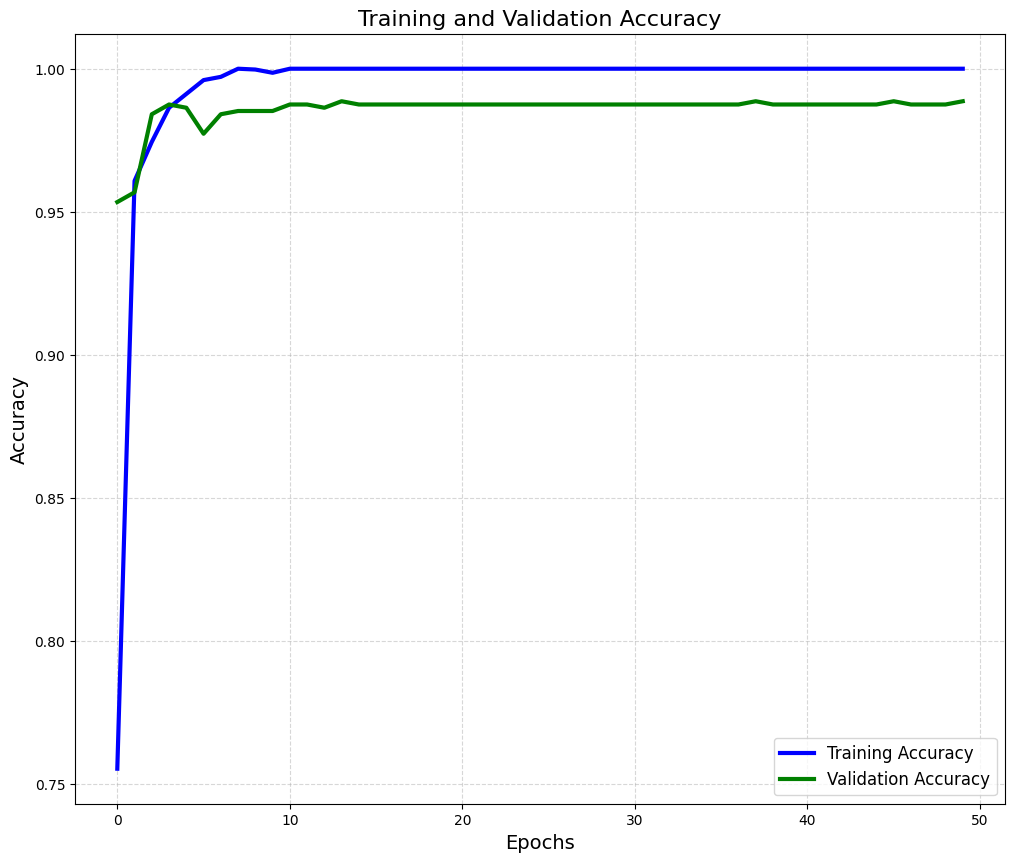

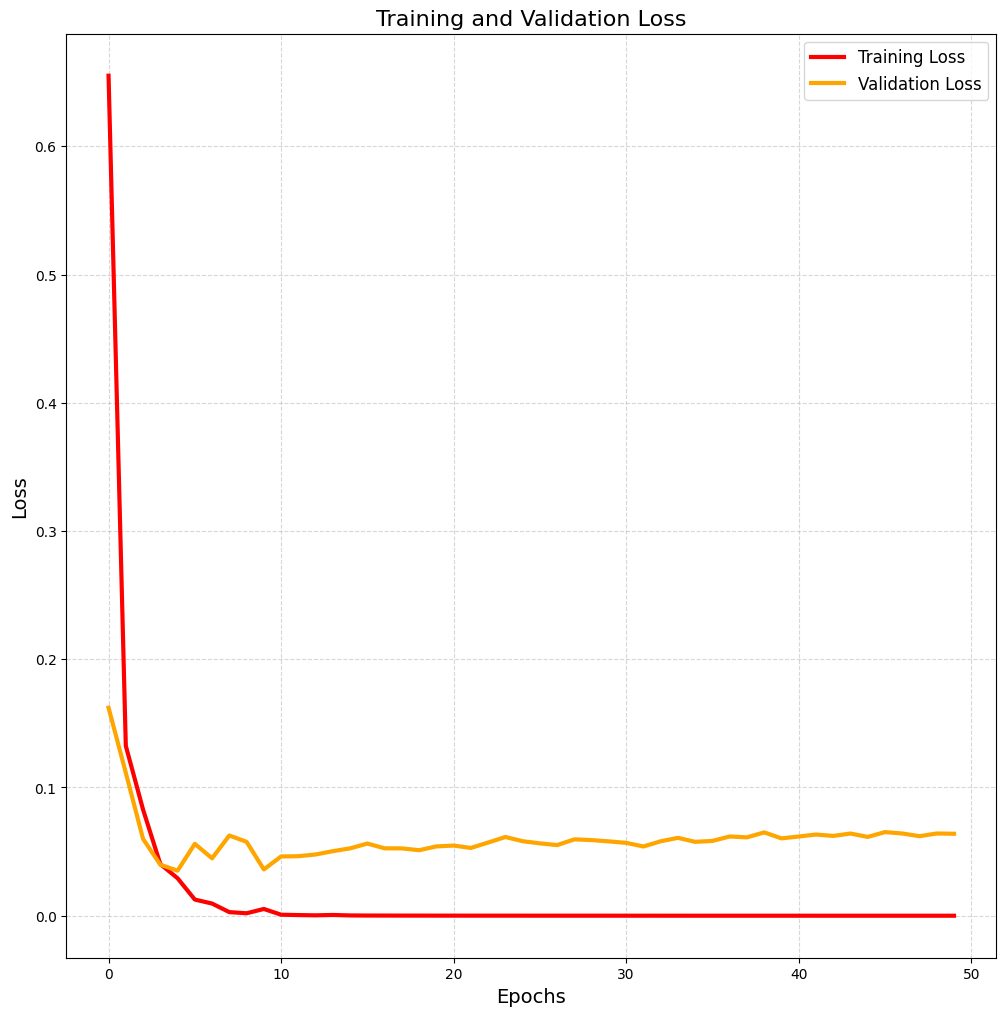

✅ Saved accuracy_curve.png and loss_curve.png


In [15]:
# =========================================================
# 12. Plot Accuracy & Loss Curves (Save Separately)
# =========================================================
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# -------------------------
# Accuracy Plot
# -------------------------
plt.figure(figsize=(12,10))
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', linewidth=3)       # bold & color
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green', linewidth=3) # bold & color
plt.legend(loc='lower right', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# ✅ Save high resolution
plt.savefig("accuracy_curve.png", dpi=600, bbox_inches="tight")
plt.show()

# -------------------------
# Loss Plot
# -------------------------
plt.figure(figsize=(12,12))
plt.plot(epochs_range, loss, label='Training Loss', color='red', linewidth=3)           # bold & color
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', linewidth=3)   # bold & color
plt.legend(loc='upper right', fontsize=12)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# ✅ Save high resolution
plt.savefig("loss_curve.png", dpi=600, bbox_inches="tight")
plt.show()

print("✅ Saved accuracy_curve.png and loss_curve.png")


In [16]:
# # # =========================================================
# # 12. Plot Accuracy & Loss Curves (Save Separately)
# # =========================================================
# import matplotlib.pyplot as plt

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(len(acc))

# # -------------------------
# # Accuracy Plot
# # -------------------------
# plt.figure(figsize=(12,10))
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")

# # ✅ Save high resolution
# plt.savefig("accuracy_curve.png", dpi=600, bbox_inches="tight")
# plt.show()

# # -------------------------
# # Loss Plot
# # -------------------------
# plt.figure(figsize=(12,12))
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")

# # ✅ Save high resolution
# plt.savefig("loss_curve.png", dpi=600, bbox_inches="tight")
# plt.show()

# print("✅ Saved accuracy_curve.png and loss_curve.png")


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


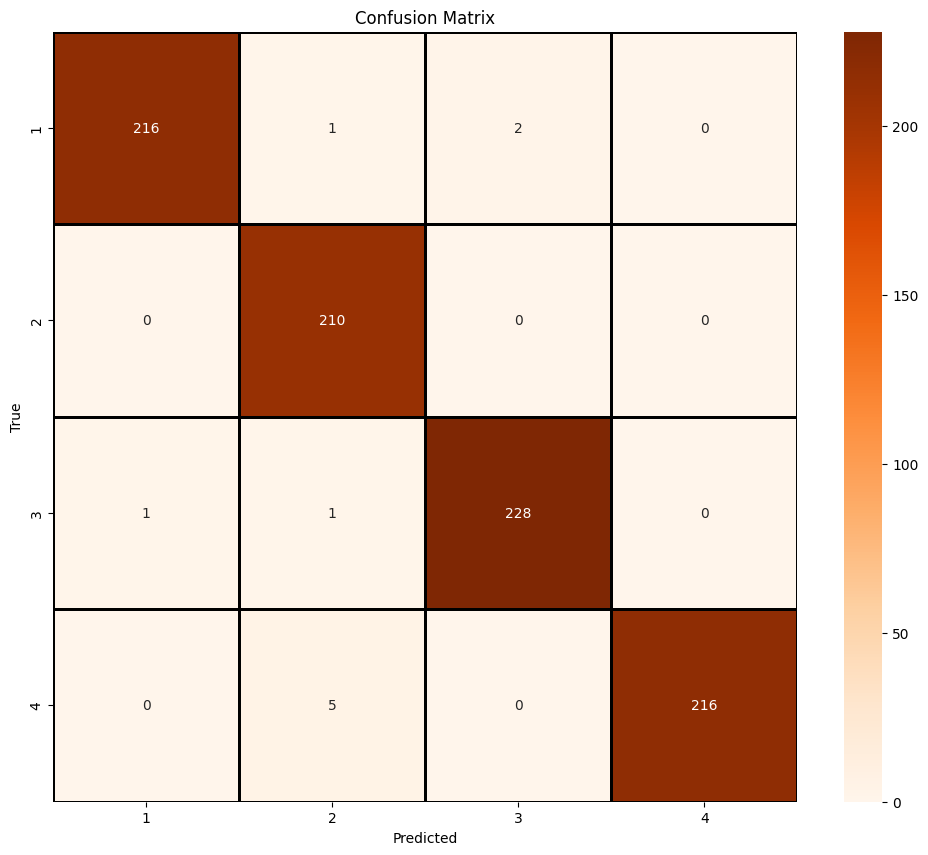

✅ Saved confusion_matrix.png
✅ Saved classification_report.csv


In [17]:
# =========================================================
# 13. Confusion Matrix & Classification Report (Save)
# =========================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Detect if y_val is one-hot or class indices
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Determine number of classes
num_classes = len(np.unique(y_true))
class_labels = [str(i+1) for i in range(num_classes)]  # Numeric labels: 1, 2, 3, ...

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            linewidths=1, linecolor='black')  # Optional: add grid lines
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# ✅ Save high-resolution PNG
plt.savefig("confusion_matrix.png", dpi=600, bbox_inches="tight")
plt.show()
print("✅ Saved confusion_matrix.png")

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# ✅ Save as CSV
report_df.to_csv("classification_report.csv", index=True)
print("✅ Saved classification_report.csv")


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


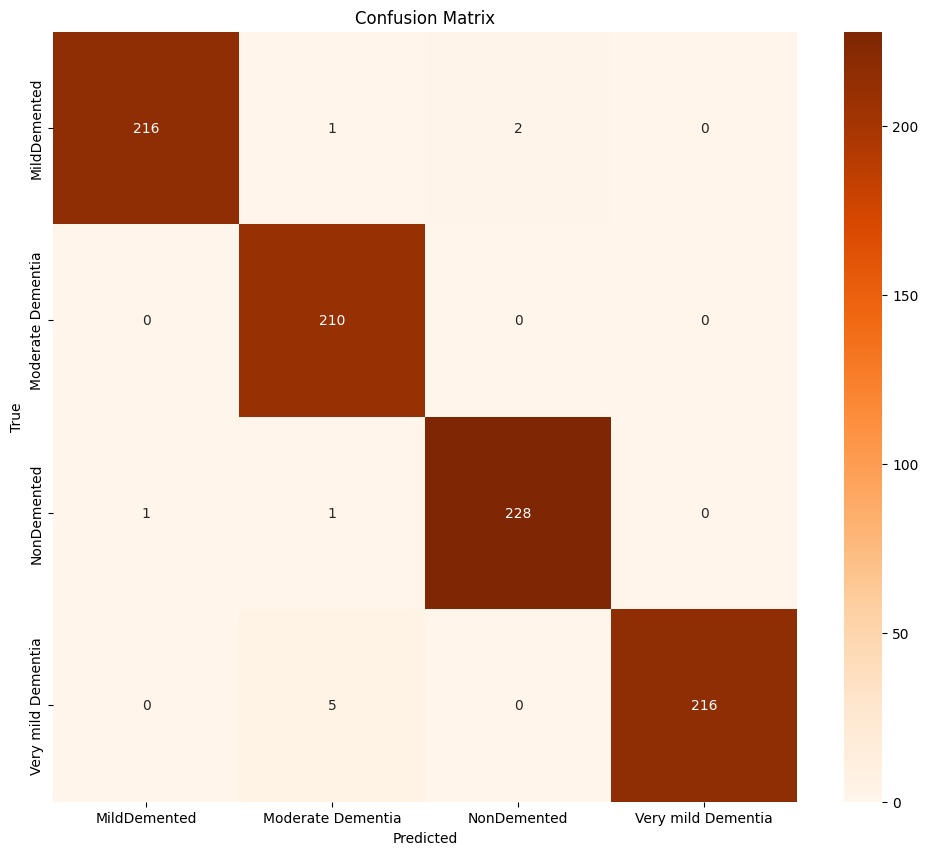

✅ Saved confusion_matrix.png
✅ Saved classification_report.csv


In [18]:
# =========================================================
# 13. Confusion Matrix & Classification Report (Save)
# =========================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Detect if y_val is one-hot or class indices
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# ✅ Save high-resolution PNG
plt.savefig("confusion_matrix.png", dpi=600, bbox_inches="tight")
plt.show()
print("✅ Saved confusion_matrix.png")

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# ✅ Save as CSV
report_df.to_csv("classification_report.csv", index=True)
print("✅ Saved classification_report.csv")


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


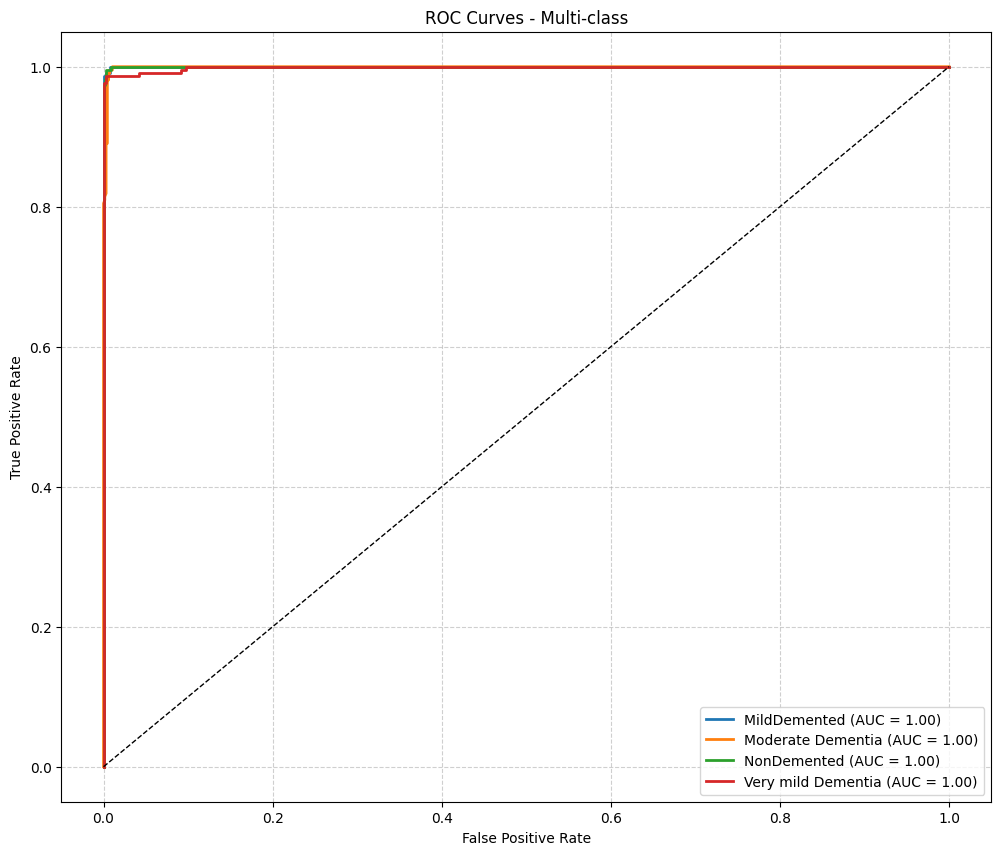

✅ Saved roc_curves.png


In [19]:
# =========================================================
# 14. ROC Curves (One-vs-Rest for Multi-class) - Save High-Res
# =========================================================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_val)

# Convert y_val to class indices if necessary
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Binarize labels for ROC
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12,10))
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal (chance)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Multi-class")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)

# ✅ Save high resolution
plt.savefig("roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved roc_curves.png")


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer

In [21]:
DATASET_DIR = "/kaggle/input/alzheimer-oas/alzheimer_n"  # your dataset path
img_size = 224

X = []
y = []

for label in sorted(os.listdir(DATASET_DIR)):
    folder = os.path.join(DATASET_DIR, label)
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            X.append(img_array)
            y.append(label)

X = np.array(X, dtype="float32")
y = np.array(y)

# One-hot encode labels
lb = LabelBinarizer()
y = lb.fit_transform(y)
num_classes = len(lb.classes_)

print("Dataset loaded:", X.shape, y.shape, "Classes:", lb.classes_)


Dataset loaded: (4000, 224, 224, 3) (4000, 4) Classes: ['MildDemented' 'Moderate Dementia' 'NonDemented' 'Very mild Dementia']


In [22]:
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# fold_no = 1
# acc_per_fold = []

# for train_idx, val_idx in kf.split(X, y):
#     print(f"\n===== Fold {fold_no} =====")

#     X_train, X_val = X[train_idx], X[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     # Build and compile model
#     model = build_cnn_vit()
#     model.compile(
#         optimizer=keras.optimizers.Adam(1e-4),
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=10,
#         batch_size=32,
#         verbose=1
#     )

#     # Evaluate
#     scores = model.evaluate(X_val, y_val, verbose=0)
#     print(f"Fold {fold_no} - Accuracy: {scores[1]*100:.2f}%")
#     acc_per_fold.append(scores[1] * 100)

#     fold_no += 1

# # =========================================================
# # 5. Final Results
# # =========================================================
# print("\nAverage Accuracy across folds:", np.mean(acc_per_fold))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# ===============================
# Custom Metrics & Losses
# ===============================
NUM_CLASSES = y.shape[1]

def mean_iou(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.one_hot(y_pred, NUM_CLASSES)
    y_true = K.one_hot(y_true, NUM_CLASSES)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())
def precision(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    return tp / (tp + fp + K.epsilon())

def recall(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    return tp / (tp + fn + K.epsilon())

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def specificity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    return tn / (tn + fp + K.epsilon())

def tversky_index(y_true, y_pred, alpha=0.5, beta=0.5):
    y_true = K.cast(y_true, 'float32')  # <-- cast to float32
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    return (tp + K.epsilon()) / (tp + alpha * fp + beta * fn + K.epsilon())

def tversky_loss(y_true, y_pred):
    return 1 - tversky_index(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    return K.pow((1 - tversky_index(y_true, y_pred)), gamma)

# ===============================
# 10-Fold Cross Validation
# ===============================
# # ===============================
# 10-Fold Cross Validation with val acc/loss
# ===============================
kf = KFold(n_splits=10, shuffle=True, random_state=42)

metrics_per_fold = []
fold_no = 1

for train_idx, val_idx in kf.split(X, y):
    print(f"\n===== Fold {fold_no} =====")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build and compile model
    model = build_cnn_vit()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy", mean_iou, precision, recall, f1_score, specificity,
            tversky_index, tversky_loss, focal_tversky_loss
        ]
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=1
    )

    # Save accuracy & loss curves per fold
    plt.figure(figsize=(7,5))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold_no} Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'fold{fold_no}_accuracy.png', dpi=300)
    plt.close()

    plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold_no} Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'fold{fold_no}_loss.png', dpi=300)
    plt.close()

    # Evaluate
    scores = model.evaluate(X_val, y_val, verbose=0)

    # Store metrics including final val acc and val loss
    val_acc_final = history.history['val_accuracy'][-1] * 100
    val_loss_final = history.history['val_loss'][-1]

    metrics_per_fold.append([
        scores[1]*100,   # Accuracy
        val_acc_final,   # Validation Accuracy
        scores[2]*100,   # MeanIoU
        scores[3]*100,   # Precision
        scores[4]*100,   # Recall
        scores[5]*100,   # F1
        scores[6]*100,   # Specificity
        scores[7]*100,   # Tversky
        scores[8],       # TverskyLoss
        scores[9],       # FocalTverskyLoss
        val_loss_final   # Validation Loss
    ])

    # ROC & AUC per class
    y_pred_probs = model.predict(X_val)
    y_true_bin = label_binarize(np.argmax(y_val, axis=1), classes=list(range(NUM_CLASSES)))
    plt.figure(figsize=(8,6))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_pred_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'Fold {fold_no} ROC Curves')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.savefig(f'fold{fold_no}_roc.png', dpi=300)
    plt.close()

    fold_no += 1

# ===============================
# Save All Fold Metrics to CSV
# ===============================
columns = ["Accuracy(%)", "Val_Accuracy(%)", "MeanIoU(%)", "Precision(%)", "Recall(%)", "F1Score(%)",
           "Specificity(%)", "TverskyCoefficient(%)", "TverskyLoss", "FocalTverskyLoss", "Val_Loss"]
df = pd.DataFrame(metrics_per_fold, columns=columns)

# Add averages & std
df.loc["Average"] = df.mean()
df.loc["StdDev"] = df.std()

df.to_csv("10fold_all_metrics.csv", index=True)
print("✅ Saved 10fold_all_metrics.csv")
print(df)



===== Fold 1 =====
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 96s 324ms/step - accuracy: 0.6633 - f1_score: 0.5499 - focal_tversky_loss: 0.5385 - loss: 0.8092 - mean_iou: 0.5469 - precision: 0.7681 - recall: 0.4844 - specificity: 0.9811 - tversky_index: 0.5445 - tversky_loss: 0.4555 - val_accuracy: 0.9700 - val_f1_score: 0.9722 - val_focal_tversky_loss: 0.1164 - val_loss: 0.0944 - val_mean_iou: 0.9467 - val_precision: 0.9757 - val_recall: 0.9688 - val_specificity: 0.9920 - val_tversky_index: 0.9393 - val_tversky_loss: 0.0607
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.9833 - f1_score: 0.9850 - focal_tversky_loss: 0.0954 - loss: 0.0615 - mean_iou: 0.9680 - precision: 0.9891 - recall: 0.9811 - specificity: 0.9964 - tversky_index: 0.9546 - tversky_loss: 0.0454 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val_focal_tversky_loss: 0.0176 - val_loss: 0.0057 - val_mean_iou: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_specificity: 1.0000 - val_tversky_index